<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Reasoning/ComputerVision/understanding_CNN_prediction_using_GRAD_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

GRAD cam algorithm intuition is that a image is classified as some class due to presence of some pixels or regions, which is gradient in mathematics. GRAD-CAM highlights those pixels.

### VGG - Reconstruction

here we are going to download pretrained VGG model and modify it to insert hook into last convolution layer such that it will be called every time a gradient with respect to the Tensor is computed.

In that hook we are going to save activations which are going to be used visualize

In [78]:
class VGG(nn.Module):
    def __init__(self):
        '''
        This VGG implementation uses same model but disect orginal model into 2 parts.
        Original = CNN(including last RELU) + Classifier

        The we add a hook to CNN part and then merge Classifier -> this way we get our
        original model, with only modification of adding a hook to last CNN layer 
        '''
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        # print("==============================================")
        # print(self.features_conv)

        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook, The hook will be called every time a gradient with respect to the 
        # Tensor is computed. The hook should have the following signature  
        # hook(grad) -> Tensor or None
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

class labels on which VGG is trained - https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [79]:
vgg = VGG()    # initialize the VGG model
vgg.eval()     # set the evaluation mode

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Conv2d

In [80]:
! wget https://stpaulpet.com/wp-content/uploads/dog-facts-cat-facts.jpg

--2022-11-08 11:36:19--  https://stpaulpet.com/wp-content/uploads/dog-facts-cat-facts.jpg
Resolving stpaulpet.com (stpaulpet.com)... 35.222.198.91
Connecting to stpaulpet.com (stpaulpet.com)|35.222.198.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36183 (35K) [image/jpeg]
Saving to: ‘dog-facts-cat-facts.jpg.5’

dog-facts-cat-facts 100%[===================>]  35.33K  --.-KB/s    in 0s      

2022-11-08 11:36:19 (79.0 MB/s) - ‘dog-facts-cat-facts.jpg.5’ saved [36183/36183]



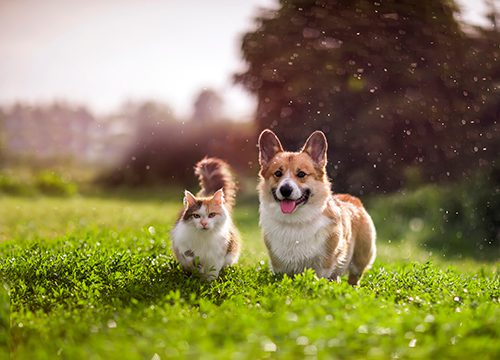

In [81]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("dog-facts-cat-facts.jpg")
cv2_imshow(img)

### Making image VGG compatible

In [82]:
# use the ImageNet transformation
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [83]:
img = cv2.imread("dog-facts-cat-facts.jpg")
img = transform(img)
img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])  # converting to an array
img.shape

torch.Size([1, 3, 224, 224])

### Generating prediction on image using VGG

In [84]:
pred = vgg(img)
pred_max = pred.argmax(dim=1)
pred_max

tensor([249])

### Generating visualization heatmap using gradient and activation

In [85]:
# get the gradient of the output with respect to the parameters of the model
pred[:, pred_max.numpy()[0]].backward()

torch.Size([1, 512, 14, 14])


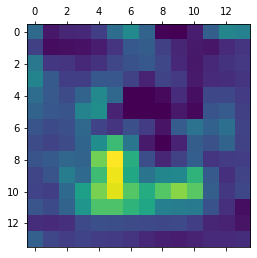

In [86]:
# pull the gradients out of the model
gradients = vgg.get_activations_gradient()
print(gradients.shape)

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [87]:
heatmap = heatmap.numpy()

### Overlapping heatmap on original image to visualize

(360, 500, 3)


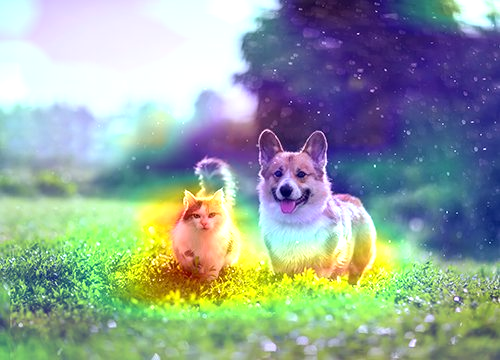

In [88]:
img = cv2.imread("dog-facts-cat-facts.jpg")
print(img.shape)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2_imshow(superimposed_img)

### References

1. https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-*ea0937c31e82*